<a href="https://colab.research.google.com/github/changdaeoh/HandsOn_ML/blob/main/ch6_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Decision Tree
* 각 분할은 CART 목적함수를 최적화하는방향으로 이루어짐
* 데이터 샘플 하나하나에 민감. robust하지않음.
* 데이터회전에 민감 -> pca나 데이터 변환이 도움이 될 수 있음.

### Decision Tree Classifier
* 특성공간을 연쇄적으로 분할, 분할된 공간의 label을 기억
* 각 sub space는 하나의 노드에 대응됨
* 관측의 특성값이 input되면, 그 특성값이 속하는 분할공간의 label로 prediction

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # 꽃잎 길이, 너비
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth = 2)
tree_clf.fit(X, y)

print(tree_clf.predict_proba([[5, 1.5], [6, 1.5]]))
print(tree_clf.predict([[5, 1.5], [6, 1.5]]))

[[0.         0.90740741 0.09259259]
 [0.         0.90740741 0.09259259]]
[1 1]


### Decision Tree Regressor
* 특성공간을 연쇄적으로 분할, 분할된 공간의 target 평균값 기억
* 각 sub space는 하나의 노드에 대응됨
* 관측의 특성값이 input되면, 그 특성값이 속하는 분할공간에 속하는 모든 샘플들의 target값 평균으로 예측

In [ ]:
from sklearn.tree import DecisionTreeRegressor

## Excersize 1. Post Pruning Method
 * Minimal Cost-Complexity Pruning

In [3]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

# feature : 30, binary label
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

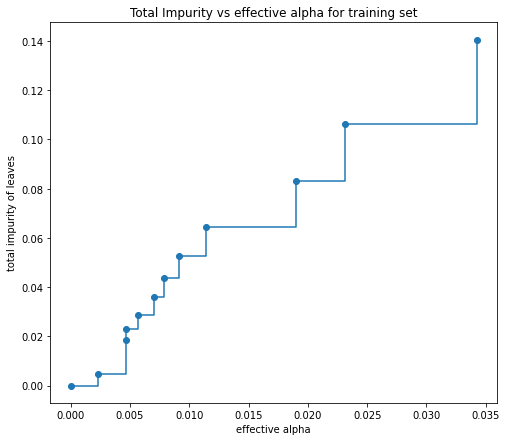

In [9]:
# Impurity vs Model complexity trade off
fig = plt.figure(figsize=(8,7))
plt.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
plt.xlabel("effective alpha")
plt.ylabel("total impurity of leaves")
plt.title("Total Impurity vs effective alpha for training set")
plt.show()

In [11]:
# 각 ccp alpha값에 대해 training
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("마지막 트리의 노드 수 : {}, 대응되는 alpha : {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1]))

마지막 트리의 노드 수 : 1, 대응되는 alpha : 0.3272984419327777


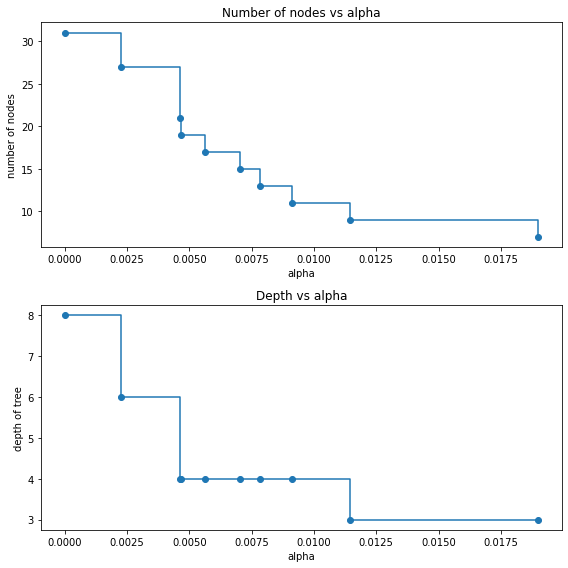

In [14]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1, figsize = (8, 8))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

### Accuracy vs Alpha trade off

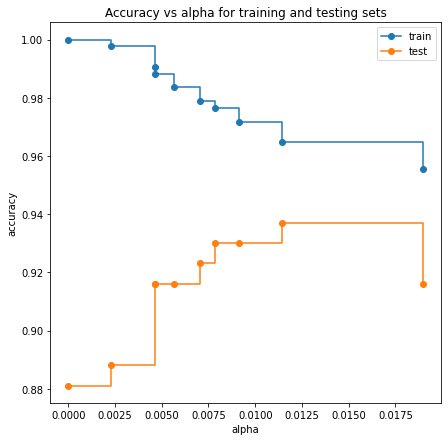

In [15]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize = (7, 7))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

## Excersize 2. Ensemble - voting

### 1. data load & hyperparameter searching

In [17]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit


X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


params = {'max_leaf_nodes': list(range(4, 80)), 'min_samples_split': [2, 3, 4, 5]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), 
                              params, verbose=0, cv=3)

grid_search_cv.fit(X_train, y_train)
print(grid_search_cv.best_estimator_)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=17,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')


### 2. subset for each tree

In [18]:
n_trees = 1000
n_instances = 100

mini_sets = []

# 트리 수만큼의 fold를 생성 (각 트리를 서로다른 fold로 학습시킬 것임)
# 각 fold별 훈련/테스트 관측비율 -> train : 100, valid : 7900
rs = ShuffleSplit(n_splits = n_trees, test_size = len(X_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

In [23]:
from sklearn.base import clone
from sklearn.metrics import accuracy_score
import numpy as np

# 최고파라미터세팅의 모델을 지정 수만큼 생성
forest = [ clone(grid_search_cv.best_estimator_) for _ in range(n_trees) ]

accuracy_scores = []

# 개별 tree와 서로다른 훈련 subset을 묶어서 iteration
for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

print("개별 트리의 평균 정확도 : ",np.mean(accuracy_scores))

개별 트리의 평균 정확도 :  0.8054499999999999


### 3. prediction ensemble

In [34]:
from scipy.stats import mode

# (1000, 2000)
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

# 지정 축에 대해 최빈값 반환 
y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

# 앙상블 정확도
print(accuracy_score(y_test, y_pred_majority_votes.reshape(-1)))

# reshape(-1) : array를 1d vector로

0.872
